In [ ]:
!pip install -U datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 27.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
! pip install torchaudio

In [ ]:
!pip install torchcodec

  Using cached torchcodec-0.8.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached torchcodec-0.8.1-cp312-cp312-manylinux_2_28_x86_64.whl (2.0 MB)


In [ ]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd

In [ ]:
import torchcodec

In [ ]:
from datasets import load_dataset, Audio

In [ ]:
SR = 32000 # SAMPLE RATE

In [ ]:
ds = load_dataset("zahidpichen/violine_dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 4
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 2
    })
})

In [ ]:
len(ds['train']['audio'])

4

In [ ]:
ds['train'][0]

{'audio': <datasets.features._torchcodec.AudioDecoder at 0x7b1e476a1490>,
 'label': None}

In [ ]:
sample = ds['train'][0]['audio']

In [ ]:
ipd.Audio(sample['array'], rate=SR)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spect(spectrogram,mode='mel'):
  """
  Mode options:
    - 'linear', 'fft', 'hz': Displays frequencies on a linear scale, determined by the FFT window and sampling rate.
    - 'log': Displays frequencies on a logarithmic scale.
    - 'mel': Displays frequencies on the Mel scale, often used for representing human perception of pitch.
    - 'cqt_hz': Displays frequencies based on the Constant-Q Transform (CQT) in Hz.
    - 'cqt_note': Displays pitches based on the CQT, labeled with musical note names (e.g., C1, G#2)
  """
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram, sr=SR, x_axis='time', y_axis=mode)
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'{mode.capitalize()} Spectrogram')
  plt.tight_layout()
  plt.show()

def plot_signal(signal):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=SR)
  plt.title('Audio Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

In [ ]:
signal = sample['array']

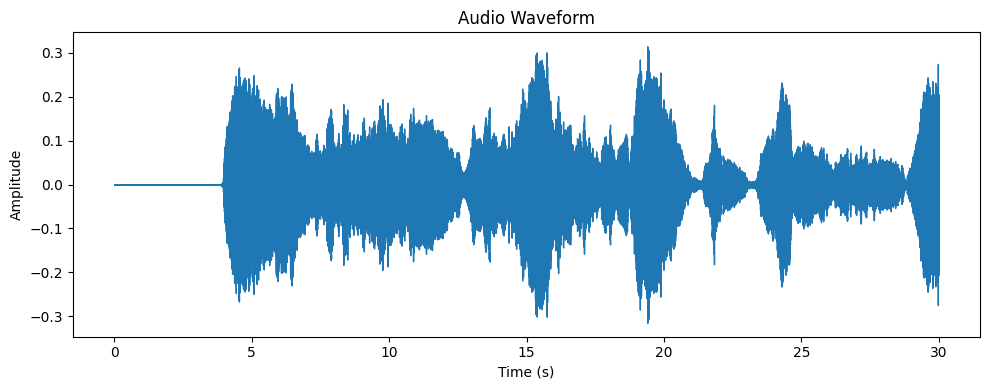

In [ ]:
plot_signal(signal)

In [ ]:
librosa.stft(y, *, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='constant', out=None)

In [ ]:
HOP = SR // 2

/tmp/ipython-input-725687381.py:14: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(spectrogram, sr=SR, x_axis='time', y_axis=mode)


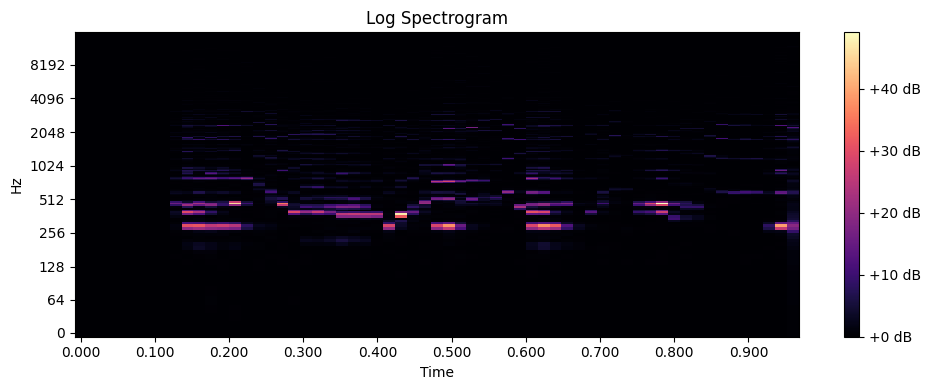

In [ ]:
plot_spect(librosa.stft(signal,hop_length=HOP),mode='log')

Frequency-based scales:
- 'linear', 'fft', 'hz': Displays frequencies on a linear scale, determined by the FFT window and sampling rate.
- 'log': Displays frequencies on a logarithmic scale.
- 'mel': Displays frequencies on the Mel scale, often used for representing human perception of pitch.
- 'cqt_hz': Displays frequencies based on the Constant-Q Transform (CQT) in Hz.
- 'cqt_note': Displays pitches based on the CQT, labeled with musical note names (e.g., C1, G#2)

In [ ]:
from torchaudio.transforms import Resample, Spectrogram, MelScale, TimeStretch, FrequencyMasking, TimeMasking

In [ ]:
import torch

In [ ]:
# Define custom feature extraction pipeline.
#
# 1. Resample audio
# 2. Convert to power spectrogram
# 3. Apply augmentations
# 4. Convert to mel-scale
#
class AudioPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=SR,
        resample_freq=SR,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        # Spectrogram to output complex values for TimeStretch
        self.spec = Spectrogram(n_fft=n_fft, power=None) # Changed to power=None

        self.time_stretch = TimeStretch(stretch_factor, fixed_rate=True) # Separate TimeStretch

        # Frequency and Time Masking operate on power/magnitude spectrograms
        self.freq_mask = FrequencyMasking(freq_mask_param=80)
        self.time_mask = TimeMasking(time_mask_param=80)

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to complex spectrogram
        complex_spec = self.spec(resampled)

        # Apply TimeStretch to the complex spectrogram
        stretched_complex_spec = self.time_stretch(complex_spec)

        # Convert to power spectrogram for masking and mel-scale
        power_spec = torch.abs(stretched_complex_spec)**2

        # Apply Frequency and Time Masking
        masked_power_spec = self.freq_mask(power_spec)
        masked_power_spec = self.time_mask(masked_power_spec)

        # Convert to mel-scale
        mel = self.mel_scale(masked_power_spec)

        return mel

In [ ]:
# Instantiate a pipeline
pipeline = AudioPipeline()

# Move the computation graph to CUDA
pipeline.to(device=torch.device("cpu"), dtype=torch.float32)

# Perform the transform
# Convert the AudioDecoder object's 'array' to a torch.Tensor
features = pipeline(torch.tensor(sample['array'], dtype=torch.float32))

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [ ]:
features

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3981e-03, 4.4430e-03,
         4.8922e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9054e-09, 6.7739e-08,
         7.1061e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5905e-09, 4.2198e-09,
         6.7611e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8055e-09, 8.3517e-10,
         6.5403e-03]])

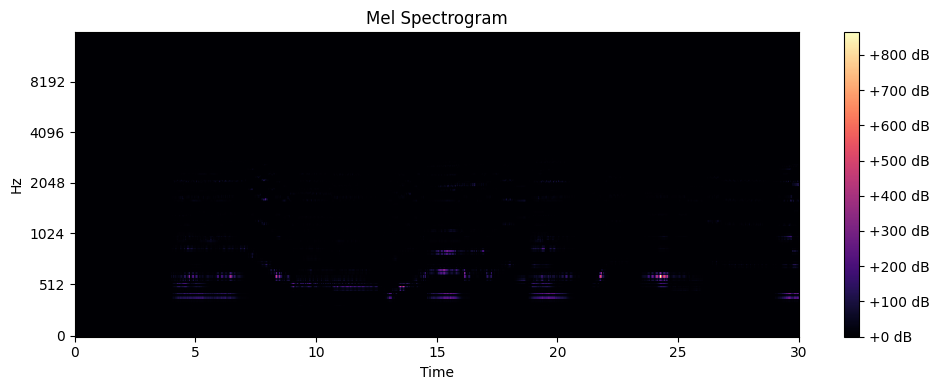

In [ ]:
# Convert the features tensor to a NumPy array
features_np = features.cpu().numpy()

plot_spect(features_np)
